In [1]:
#Getting Data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.extract.nflreadpy_extract import *
from src.transform.transform_module_api import DataTransformerTeam
from src.transform.fe_module import *

dfs = []
for year in range(1999, 2026):
    df = get_reg_team_stats(year)
    dfs.append(df)

team_dfs = []
for df in dfs:
    clean = DataTransformerTeam.clean(df)
    team_dfs.append(team_stats(clean))

records_dfs = []
for year in range(1999, 2026):
    df = get_schedule(year)
    records_dfs.append(df)

team_records_dfs = []
for df in records_dfs:
    records = team_records(df)
    team_records_dfs.append(records)

# Dictionaries with overall team_stats and team_records in the format of {Year: DataFrame}
years = list(range(1999, 2026))
season_stat_map = {year:df for year,df in zip(years, team_dfs)}
season_record_map = {year:df for year,df in zip(years, team_records_dfs)}


#print(season_stat_map)
#print(season_record_map)

In [2]:
# Obtaining the team_records (wins and losses)

team_records = {}

for year in season_stat_map.keys():
    schedule = nfl.load_schedules(year).to_pandas()

    wins = (
        schedule
        .assign(
            home_win=lambda x: (x.home_score > x.away_score).astype(int),
            away_win=lambda x: (x.away_score > x.home_score).astype(int)
        )
    )

    home_wins = wins.groupby(["season", "home_team"])["home_win"].sum()
    away_wins = wins.groupby(["season", "away_team"])["away_win"].sum()

    total_wins = home_wins.add(away_wins, fill_value=0).reset_index()
    total_wins.columns = ["season", "team", "wins"]

    home_games = schedule.groupby(["season", "home_team"]).size()
    away_games = schedule.groupby(["season", "away_team"]).size()

    total_games = home_games.add(away_games, fill_value=0).reset_index()
    total_games.columns = ["season", "team", "games_played"]
    total_wins['losses'] = total_games['games_played'] - total_wins['wins']

    team_records.setdefault(year, total_wins)

In [3]:
# testing fe_module
from src.transform.fe_module import *

season_stats = {}
season_averages = {}
for (year, df), (r_year, r_df) in zip(season_stat_map.items(), season_record_map.items()):
    percent = stat_percentages(df, r_df)
    season_stats.setdefault(year, percent)

for year, df in season_stat_map.items():
    averages = league_averages(df)
    season_averages.setdefault(year, averages)

# season_stats contains pass %, rush %, ypa(yards per pass), ypr(yards per rush), and win % for each team for each season
# season_stats is a dictionary of {year: dataframe}
#print(season_stats)
# season_average contains averages over the whole league for each season, avg pass attempts, avg rush attempts, avg pass yards, avg rush yards
# season_average is a dictionary of {year: {avg_pass_attempts: val, avg_rush_attempts: val...}} 
#print(season_averages)

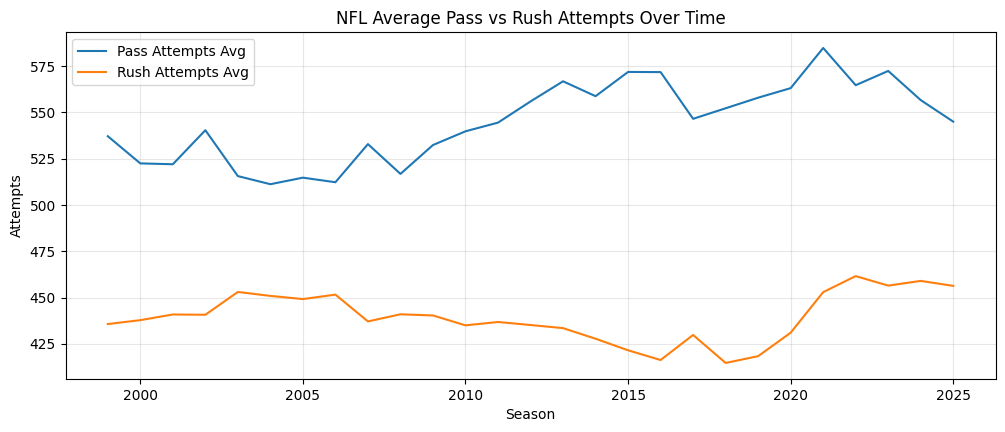

In [4]:
attempts_rows = []

for year, dict in season_averages.items():
    attempts_rows.append({
        'season' : year,
        'pass_attempts_avg' : dict['avg_pass_attempts'],
        'rush_attempts_avg' : dict['avg_rush_attempts']
    })

yearly_attempts = pd.DataFrame(attempts_rows).sort_values('season')

fig, ax = plt.subplots(figsize=(12, 4.5))
ax.plot(yearly_attempts['season'], yearly_attempts['pass_attempts_avg'], label='Pass Attempts Avg')
ax.plot(yearly_attempts['season'], yearly_attempts['rush_attempts_avg'], label='Rush Attempts Avg')

ax.set_title('NFL Average Pass vs Rush Attempts Over Time')
ax.set_xlabel('Season')
ax.set_ylabel('Attempts')
ax.legend()
ax.grid(alpha=0.3)

plt.show()

<Axes: xlabel='pass_percent', ylabel='win_percent'>

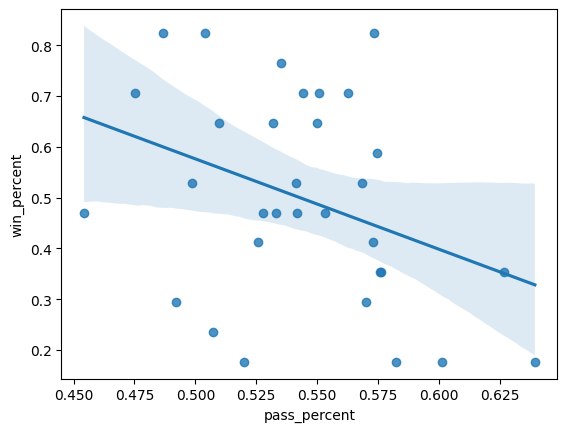

In [14]:
# pass% vs win% scatterplot for 2025
sns.regplot(data = season_stats[2025], x = 'pass_percent', y = 'win_percent')


<Axes: xlabel='ypa', ylabel='ypr'>

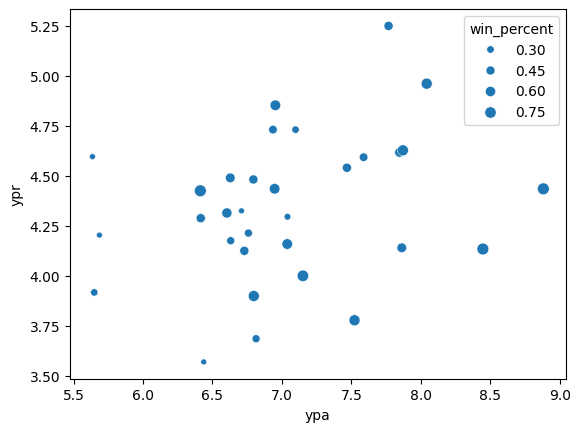

In [6]:
# pass efficiency vs rush efficiency scatterplot for 2025
sns.scatterplot(data= season_stats[2025], x = 'ypa', y = 'ypr', size='win_percent')

<Axes: xlabel='year', ylabel='avg_pass_percent'>

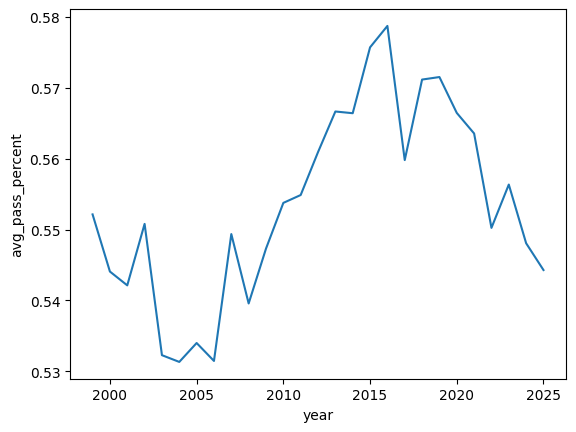

In [7]:
# histogram of pass_percentage by season
average_df = pd.DataFrame.from_dict(season_averages, orient='index').reset_index()
average_df = average_df.rename(columns = {'index' : 'year'})
sns.lineplot(data = average_df, x = 'year', y = 'avg_pass_percent')

<Axes: xlabel='pass_attempts', ylabel='wins'>

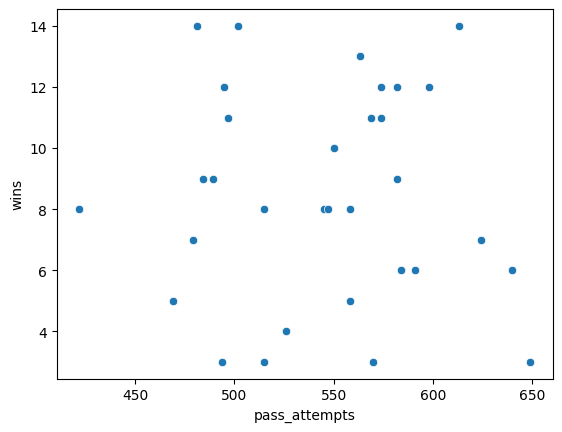

In [8]:
# scatter plot of pass attempts vs wins compared to scatter plot of pass efficiency vs wins
combined_df = season_stat_map[2025].merge(season_record_map[2025], on = 'team')
sns.scatterplot(data = combined_df, x = 'pass_attempts', y = 'wins')

<Axes: xlabel='ypa', ylabel='wins'>

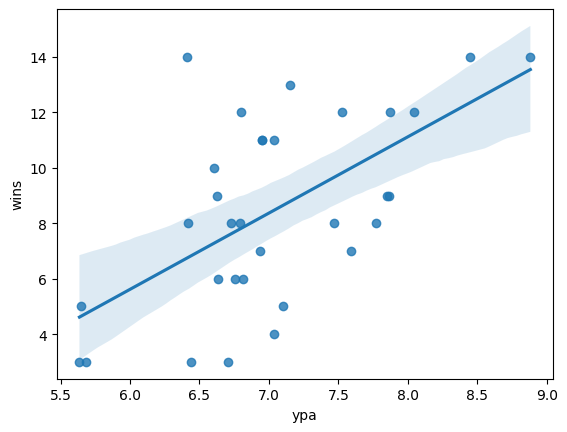

In [13]:
combined_df = season_stats[2025].merge(season_record_map[2025], on = 'team')
sns.regplot(data = combined_df, x = 'ypa', y = 'wins')

In [10]:
print(season_record_map[2025])

    season team  wins  losses
0     2025  ARI     3      14
1     2025  ATL     8       9
2     2025  BAL     8       9
3     2025  BUF    12       5
4     2025  CAR     8       9
5     2025  CHI    11       6
6     2025  CIN     6      11
7     2025  CLE     5      12
8     2025  DAL     7      10
9     2025  DEN    14       3
10    2025  DET     9       8
11    2025   GB     9       8
12    2025  HOU    12       5
13    2025  IND     8       9
14    2025  JAX    13       4
15    2025   KC     6      11
16    2025   LA    12       5
17    2025  LAC    11       6
18    2025   LV     3      14
19    2025  MIA     7      10
20    2025  MIN     9       8
21    2025   NE    14       3
22    2025   NO     6      11
23    2025  NYG     4      13
24    2025  NYJ     3      14
25    2025  PHI    11       6
26    2025  PIT    10       7
27    2025  SEA    14       3
28    2025   SF    12       5
29    2025   TB     8       9
30    2025  TEN     3      14
31    2025  WAS     5      12
